In [40]:
from __future__ import division

from biom import load_table
from picrust.util import convert_precalc_to_biom, get_picrust_project_dir
from os import path
import gzip
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plts
from statsmodels.sandbox.stats.multicomp import multipletests
import matplotlib.pyplot as plt
from collections import defaultdict, OrderedDict
from skbio import TreeNode
from itertools import combinations
from scipy.optimize import curve_fit
import networkx as nx
from tqdm import tqdm_notebook
from scipy.stats import mannwhitneyu, wilcoxon, hypergeom
from statsmodels.formula.api import ols

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
sns.set()

def is_closed(otu_id):
    try:
        int(otu_id)
        return True
    except ValueError:
        return False

def sparcc_filter(table):
    otus_to_keep = list()
    for value, id_, _ in table.iter(axis='observation'):
        if np.mean(value) > 2:
            otus_to_keep.append(id_)
    return table.filter(otus_to_keep, axis='observation', inplace=False)

def p_adjust(pvalues, method='fdr_bh'):
    res = multipletests(pvalues, method=method)
    return np.array(res[1], dtype=float)

xdata = np.linspace(-.5, 2, 100)
def func(x, a, b, c):
    return a*np.log(x+b)+c

def percent_shared(otu_i_arr, otu_j_arr):
    otu_data = np.stack((otu_i_arr, otu_j_arr)).astype(bool).sum(axis=0)
    shared = np.sum(otu_data == 2)
    return shared/np.sum(otu_data > 0)

!pwd

/Users/shafferm/lab/QIIME_workshop_2018


# QIIME Workshop San Diego 2018

## Read in data
All the data for this talk. First we read in the data and print some summary statistics. This includes the original table and collapsed as well as the modules file. Also the open reference and greengenes tree.

In [2]:
table = load_table("otu_table.BCN0.nopwid.biom")
print "Open reference table has %s OTUs" % table.shape[0]
closed_otus = [i for i in table.ids(axis='observation') if is_closed(i)]
print "Closed reference table has %s OTUs" % len(closed_otus)

Open reference table has 8157 OTUs
Closed reference table has 1444 OTUs


In [3]:
table_filt = sparcc_filter(table)
print "Open reference filtered table has %s OTUs" % table_filt.shape[0]
closed_otus_filt = [i for i in table_filt.ids(axis='observation') if is_closed(i)]
print "Closed reference filtered table has %s OTUs" % len(closed_otus_filt)

Open reference filtered table has 1255 OTUs
Closed reference filtered table has 686 OTUs


In [4]:
collapsed_table = load_table("SCNIC_BCN0_nopwid/min_r35/collapsed.biom")
print "Collapsed open reference table has %s OTUs" % collapsed_table.shape[0]
collapsed_table_filt = sparcc_filter(collapsed_table)
print "Filtered collapsed open reference table has %s OTUs" % collapsed_table_filt.shape[0]

Collapsed open reference table has 7952 OTUs
Filtered collapsed open reference table has 1050 OTUs


In [5]:
print "%s samples in the dataset" % table_filt.shape[1]

141 samples in the dataset


In [6]:
meta = pd.read_table('SRP068240_qiime.txt', index_col=0)
meta = meta.loc[table.ids()]
meta.head()

,Anal_cytology_s,AvgSpotLen_l,BioSample_s,CD4_Tcell_counts_s,HBV_coinfection_s,HCV_coinfection_s,HIV_Profile_s,HIV_RiskGroup_s,HIV_serostatus_s,HIV_viral_load_s,...,SRA_Study_s,biotic_relationship_s,env_biome_s,env_feature_s,env_material_s,host_s,host_body_product_s,isol_growth_condt_s,strain_s,Description
#SampleID,,,,,,,,,,,,,,,,,,,,,
SRX1525078,Normal,597,SAMN04382182,561.0,negative,negative,concordant,hts,positive,undetectable,...,SRP068240,symbiont,human-associated habitat,human gut,feces,Homo sapiens,stool,https://mobio.com/powersoil-dna-isolation-kit....,not applicable,SRX1525078
SRX1525079,HSIL,597,SAMN04382183,1517.0,negative,negative,concordant,hts,positive,undetectable,...,SRP068240,symbiont,human-associated habitat,human gut,feces,Homo sapiens,stool,https://mobio.com/powersoil-dna-isolation-kit....,not applicable,SRX1525079
SRX1525080,HSIL,596,SAMN04382184,767.0,negative,negative,concordant,msm,positive,undetectable,...,SRP068240,symbiont,human-associated habitat,human gut,feces,Homo sapiens,stool,https://mobio.com/powersoil-dna-isolation-kit....,not applicable,SRX1525080
SRX1525081,LSIL,596,SAMN04382185,NaN,negative,negative,negative,msm,negative,NaN,...,SRP068240,symbiont,human-associated habitat,human gut,feces,Homo sapiens,stool,https://mobio.com/powersoil-dna-isolation-kit....,not applicable,SRX1525081
SRX1525082,Normal,596,SAMN04382186,NaN,negative,negative,negative,msm,negative,NaN,...,SRP068240,symbiont,human-associated habitat,human gut,feces,Homo sapiens,stool,https://mobio.com/powersoil-dna-isolation-kit....,not applicable,SRX1525082


In [7]:
print "%s individuals in cohort who participate in MSM" % sum(meta.HIV_RiskGroup_s=='msm')
print "%s individuals in cohort are HIV positive" % sum(meta.HIV_serostatus_s=='positive')
print "%s individuals in cohort who participate in MSM and are HIV positive" % sum((meta.HIV_RiskGroup_s=='msm') & (meta.HIV_serostatus_s=='positive'))

100 individuals in cohort who participate in MSM
114 individuals in cohort are HIV positive
77 individuals in cohort who participate in MSM and are HIV positive


In [8]:
modules = OrderedDict()
with open("SCNIC_BCN0_nopwid/min_r35/modules.txt") as f:
    for line in f.readlines():
        line = line.split()
        modules[line[0]] = line[1:]

In [9]:
print "There are %s modules" % len(modules)

There are 140 modules


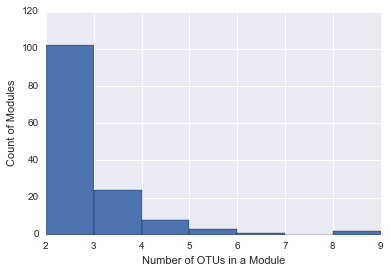

In [10]:
_ = plt.hist([len(i) for i in modules.values()], bins=np.linspace(2,9,8))
_ = plt.xlabel("Number of OTUs in a Module")
_ = plt.ylabel("Count of Modules")

In [11]:
tre = TreeNode.read("rep_set.tre")
# taken from https://github.com/biocore/scikit-bio/issues/1520
for n in tre.postorder(include_self=True):
    if n.length is None:
        n.length = 0
tre_99 = TreeNode.read("references/greengenes/trees/99_otus.tree")
# taken from https://github.com/biocore/scikit-bio/issues/1520
for n in tre_99.postorder(include_self=True):
    if n.length is None:
        n.length = 0
# following lines are adapted from picrust's predict_metagenomes.py script
precalc_data_dir = path.join(get_picrust_project_dir(),'picrust','data')
precalc_file_name='_'.join(['ko', '13_5', 'precalculated.tab.gz'])
genome_table_fp = path.join(precalc_data_dir, precalc_file_name)
genome_table_fh = gzip.open(genome_table_fp, 'rb')
genome_table = convert_precalc_to_biom(genome_table_fh, [i for i in table_filt.ids(axis='observation') if is_closed(i)], transpose=True)
genome_table.filter(genome_table.ids(axis="observation")[genome_table.sum(axis="observation")>0],
                    axis='observation', inplace=True)

4846 x 686 <class 'biom.table.Table'> with 690092 nonzero entries (20% dense)

## Annotate correlations

Take the correlations and annotate with phylogenetic distance, shared genes in PICRUSt, module membership and closed reference status.

In [12]:
correls = pd.read_table("SCNIC_BCN0_nopwid/correls.txt", index_col=(0,1))

In [13]:
correls_tip_tips = tre.tip_tip_distances(set([otu for otu_pair in correls.index for otu in otu_pair]))
correls_99_tip_tips = tre_99.tip_tip_distances(set([otu for otu_pair in correls.index for otu in otu_pair if is_closed(otu)]))

In [14]:
correlated_list = list()
module_member_list = list()
module_three_plus = list()
module_closed_three_plus = list()
for otu_pair, row in tqdm_notebook(correls.iterrows(), total=len(correls)):
    module_member = 'None'
    module_three_plus_member = False
    module_closed_three_plus_member = False
    correlated = row.r > .35
    correlated_list.append(correlated)
    if correlated:
        for module, otus in modules.iteritems(): # check if otu pair is from a module
            if otu_pair[0] in otus and otu_pair[1] in otus:
                module_member = module
                if len(otus) >= 3:
                    module_three_plus_member = True
                    if is_closed(otu_pair[0]) and is_closed(otu_pair[1]): # if both closed and more than 3 closed otus 
                        if len([i for i in otus if is_closed(i)]) >= 3:
                            module_closed_three_plus_member = True
                break                
    else: # if not correlated include for not closed and in closed include if both are closed ref
        module_three_plus_member = True
        if is_closed(otu_pair[0]) and is_closed(otu_pair[1]):
            module_closed_three_plus_member = True
    module_member_list.append(module_member)
    module_three_plus.append(module_three_plus_member)
    module_closed_three_plus.append(module_closed_three_plus_member)
correls['correlated'] = correlated_list
correls['module'] = module_member_list
correls['three_plus'] = module_three_plus
correls['three_plus_closed'] = module_closed_three_plus

HBox(children=(IntProgress(value=0, max=788140), HTML(value=u'')))

In [15]:
both_closed = list()
pds = list()
closed_pds = list()
percent_shareds = list()
for otu_pair, row in tqdm_notebook(correls.iterrows(), total=correls.shape[0]):
    both_closed.append(is_closed(otu_pair[0]) and is_closed(otu_pair[1]))
    pds.append(correls_tip_tips[otu_pair])
    if is_closed(otu_pair[0]) and is_closed(otu_pair[1]):
        closed_pds.append(correls_99_tip_tips[otu_pair])
        percent_shareds.append(percent_shared(genome_table.data(otu_pair[0]), genome_table.data(otu_pair[1])))
    else:
        closed_pds.append('None')
        percent_shareds.append('None')
correls['PD'] = pds
correls['PD_closed'] = closed_pds
correls['percent_shared'] = percent_shareds
correls['both_closed'] = both_closed

HBox(children=(IntProgress(value=0, max=788140), HTML(value=u'')))

In [16]:
display(correls.head())

r  correlated module  three_plus  \
           Unnamed: 1                                            
denovo3058 denovo3050  0.006841       False   None        True   
           denovo3053  0.021374       False   None        True   
           296361     -0.022753       False   None        True   
           denovo4491  0.014180       False   None        True   
           denovo4722  0.007368       False   None        True   

                       three_plus_closed       PD PD_closed percent_shared  \
           Unnamed: 1                                                        
denovo3058 denovo3050              False  0.62990      None           None   
           denovo3053              False  0.59592      None           None   
           296361                  False  0.70538      None           None   
           denovo4491              False  0.73041      None           None   
           denovo4722              False  0.13825      None           None   

                       both_closed  
           Unnamed: 1               
denovo3058 denovo3050        False  
           denovo3053        False  
           296361            False  
           denovo4491        False  
           denovo4722        False

## Phylogenetic Enrichment of Modules

Measure phylogenetic enrichment of modules relative to uncorrelated observations.

In [17]:
pd_stats = pd.DataFrame(index=['statistic', 'pvalue'])
noncorrel = correls.loc[correls.three_plus & ~correls.correlated]
for module, otus in tqdm_notebook(modules.iteritems(), total=len(modules)):
    if len(otus) >= 3:
        if module != 'None':
            frame = correls.loc[correls.module==module]
            res = mannwhitneyu(frame.PD, noncorrel.PD, alternative='less')
            pd_stats[module] = [res.statistic, res.pvalue]
pd_stats = pd_stats.transpose()
pd_stats['adj_pvalue'] = p_adjust(pd_stats.pvalue)
display(pd_stats)

HBox(children=(IntProgress(value=0, max=140), HTML(value=u'')))

,statistic,pvalue,adj_pvalue
module_0,9078300.0,5.457727e-02,8.641402e-02
module_1,4366550.0,1.626136e-08,6.179318e-07
module_2,4795751.5,1.057362e-01,1.385508e-01
module_3,2545742.0,2.690613e-02,4.647422e-02
module_4,131395.5,5.982908e-08,1.136752e-06
module_5,742262.0,4.447000e-06,5.632866e-05
module_6,2477538.0,5.855762e-01,6.181082e-01
module_7,219417.5,5.960687e-05,4.530122e-04
module_8,1017208.0,7.933473e-03,1.586695e-02
module_9,743680.5,1.840809e-03,5.036666e-03


In [18]:
significant_modules = pd_stats.index[pd_stats.adj_pvalue<.1]
print "%s modules are significantly closer related phylogenetically than noncorrelated values" % len(significant_modules)
print "%s percent of modules (greater than size three) are significantly closer related phylogenetically than uncorrelated values" % (len(significant_modules)/len(pd_stats))

24 modules are significantly closer related phylogenetically than noncorrelated values
0.631578947368 percent of modules (greater than size three) are significantly closer related phylogenetically than uncorrelated values


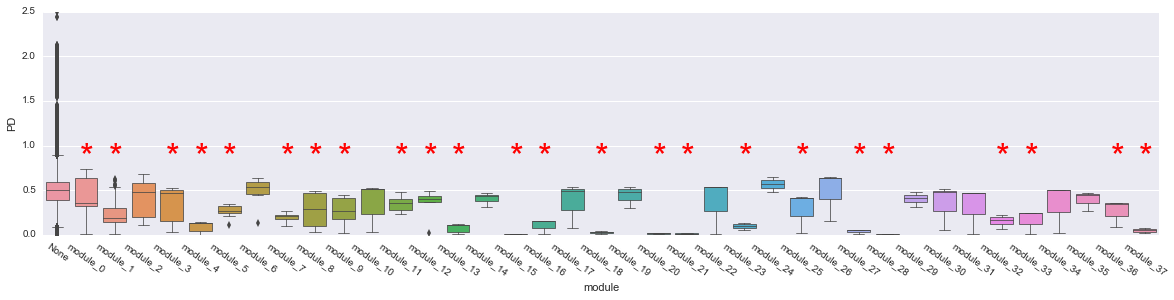

In [19]:
fig, ax = plt.subplots(figsize=(20, 4))
ax = sns.boxplot(x='module', y='PD', data=correls.loc[correls.three_plus], linewidth=.75, ax=ax,
                 order=['None']+list(pd_stats.index))
for i, module in enumerate(['None']+list(pd_stats.index)):
    if module in significant_modules:
        _ = ax.text(i-.2, .75, '*', color='red', fontsize=35)
_ = ax.set_xticklabels(ax.get_xticklabels(),rotation=325)

## Functional enrichment of modules relative to phylogenetic distance

Here we find modules that are enriched with shared genes relative to their phylogenetic relatedness as measured by PICRUSt.

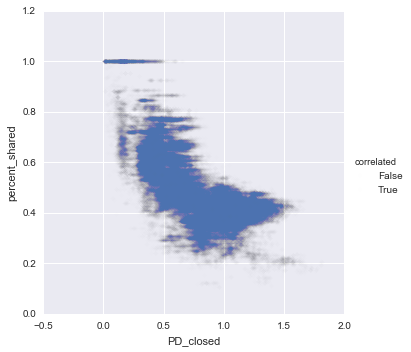

In [20]:
_ = sns.lmplot(y='percent_shared', x='PD_closed', hue='correlated', scatter_kws={'alpha': .002}, data=correls.loc[correls.three_plus_closed], fit_reg=False)

In [21]:
noncorrel_closed = correls.loc[correls.three_plus_closed & ~correls.correlated]
popt_noncorrel, _ = curve_fit(func, noncorrel_closed.PD_closed.astype(float),
                              noncorrel_closed.percent_shared.astype(float))
noncorrel_residuals = noncorrel_closed.percent_shared - \
                      func(noncorrel_closed.PD_closed.astype(float), *popt_noncorrel)
good_modules = [module for module, otus in modules.iteritems() if len([i for i in otus if is_closed(i)])>2]
def test_resids(frame, popt, func, noncorrel_resids):
    resids = frame.percent_shared - func(frame.PD_closed.astype(float), *popt_noncorrel)
    return mannwhitneyu(resids, noncorrel_resids, alternative='greater')
    
module_pvalues = [test_resids(correls.loc[correls.three_plus_closed & (correls.module==module)], popt_noncorrel, func, noncorrel_residuals).pvalue
                  for module in good_modules]
module_adj_pvalues = {good_modules[i]: p_adj for i, p_adj in enumerate(p_adjust(module_pvalues))}

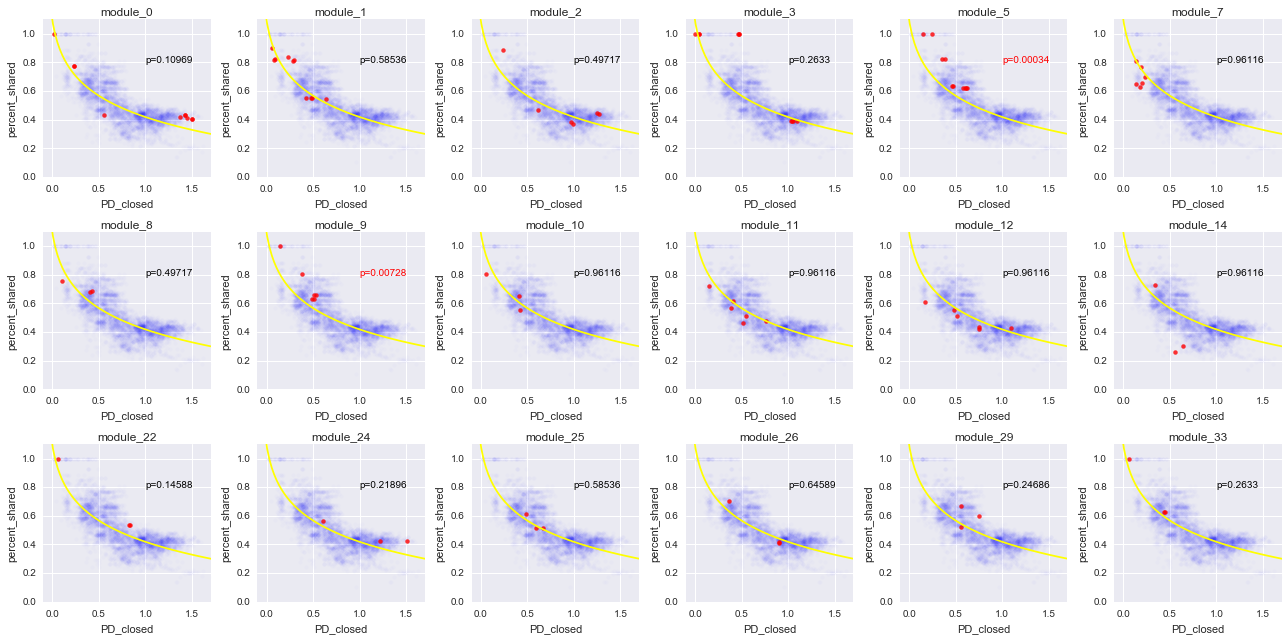

In [22]:
# figure set up
rows = 6
cols = int(np.ceil(len(good_modules)/rows))
fig_len = 3
f, axarr = plt.subplots(cols, rows, figsize=(rows*fig_len, cols*fig_len))
module_grouped_correls = correls.loc[correls.three_plus_closed].groupby('module')
noncorrel_closed = noncorrel_closed.sample(5000)
for i in xrange(axarr.shape[0]):
        for j in xrange(axarr.shape[1]):
            ax = axarr[i, j]
            current_number = i*axarr.shape[1]+j
            if current_number < len(modules.keys()):
                module = good_modules[current_number]
                frame = module_grouped_correls.get_group(module)
                # plots
                _ = sns.regplot(y='percent_shared', x='PD_closed', data=noncorrel_closed,
                                fit_reg=False, ax=ax, scatter_kws={'alpha': .01}, color='blue')
                _ = ax.plot(xdata, func(xdata, *popt_noncorrel), color='yellow')
                _ = sns.regplot(y='percent_shared', x='PD_closed', data=frame, fit_reg=False, ax=ax, color='red')
                # annotations
                pvalue = module_adj_pvalues[module]
                text_color = 'red' if pvalue < .05 else 'black'
                _ = ax.text(1, .8, 'p=%s' % np.round(pvalue, 5), color=text_color)
                # style
                _ = ax.set_title(module) 
                _ = ax.set_xlim(-.1, 1.7)
                _ = ax.set_ylim(0, 1.1)
_ = plt.tight_layout()

## Finding Associations of Features with HIV and MSM 

In [23]:
def calculate_stats(table_filt, meta):
    df = table_filt.to_dataframe().transpose()
    df.columns = ['otu_'+i for i in df.columns]
    df = df.loc[df.index & meta.index]
    meta = meta.loc[df.index & meta.index]
    full_table = df.to_dense().join(meta)
    results = pd.DataFrame()
    for otu in df.columns:
        formula = '%s ~ C(HIV_serostatus_s) + C(HIV_RiskGroup_s) + C(HIV_serostatus_s):C(HIV_RiskGroup_s)' % otu
        model = ols(formula, full_table).fit() 
        results[otu] = model.pvalues.set_value('f_pvalue', model.f_pvalue)
    results = results.transpose()
    results['f_pvalue_adj'] = multipletests(results['f_pvalue'], method='fdr_bh')[1]
#     return results.sort_values('f_pvalue_adj')
    return results

def filter_table(table, min_samples=None):
    """filter relative abundance table, by default throw away things greater than 1/3 zeros"""
    table = table.copy()
    # first sample filter
    if min_samples is not None:
        to_keep = [i for i in table.ids(axis='observation')
                   if sum(table.data(i, axis='observation') != 0) >= min_samples]
    else:
        to_keep = [i for i in table.ids(axis='observation')
                   if sum(table.data(i, axis='observation') != 0) >= table.shape[1]/3]
    table.filter(to_keep, axis='observation')
    return table

rar_level = int(sorted(table.sum(axis='sample'))[0])
min_samples = np.ceil(table.shape[1]*.5)

In [24]:
table_rar = table.subsample(rar_level)
table_rar_filt = filter_table(table_rar, min_samples)
open_stats = calculate_stats(table_rar_filt, meta)
display(open_stats.head())

,Intercept,C(HIV_serostatus_s)[T.positive],C(HIV_RiskGroup_s)[T.msm],C(HIV_serostatus_s)[T.positive]:C(HIV_RiskGroup_s)[T.msm],f_pvalue,f_pvalue_adj
otu_845834,0.036950,0.343068,0.630283,0.806073,0.036711,0.102725
otu_845038,0.776562,0.228764,0.539229,0.404985,0.511607,0.639509
otu_607612,0.111239,0.912103,0.505129,0.979973,0.283393,0.416681
otu_209891,0.351540,0.700994,0.789545,0.961514,0.628121,0.724755
otu_355333,0.828636,0.969979,0.202095,0.798154,0.000402,0.002263


In [25]:
collapsed_table_rar = collapsed_table.subsample(rar_level)
collapsed_table_rar_filt = filter_table(collapsed_table_rar, min_samples)
collapsed_stats = calculate_stats(collapsed_table_rar_filt, meta)
display(collapsed_stats.head())

,Intercept,C(HIV_serostatus_s)[T.positive],C(HIV_RiskGroup_s)[T.msm],C(HIV_serostatus_s)[T.positive]:C(HIV_RiskGroup_s)[T.msm],f_pvalue,f_pvalue_adj
otu_607612,0.121917,0.962846,0.438501,0.874283,0.279436,0.387789
otu_209891,0.477430,0.693192,0.845123,0.831403,0.544942,0.638897
otu_587502,0.002549,0.144066,0.690856,0.530978,0.119700,0.195674
otu_567381,0.396326,0.439875,0.706461,0.615030,0.801512,0.876181
otu_1107949,0.878538,0.723601,0.930438,0.977739,0.811756,0.876181


In [26]:
print "%s features are present in more than half of features in original table" % table.shape[0]
print "%s features are present in more than half of features in collapsed table" % collapsed_table.shape[0]
collapsed_total_features = sum([1 if 'module' not in feature else len(modules[feature])
                                for feature in collapsed_table.ids(axis='observation')])
print "%s total features are present in more than half of features in collapsed table" % collapsed_total_features
print "%f percent change with collapsing" % ((collapsed_total_features-table.shape[0])/table.shape[0]*100)

8157 features are present in more than half of features in original table
7952 features are present in more than half of features in collapsed table
8157 total features are present in more than half of features in collapsed table
0.000000 percent change with collapsing


In [27]:
print "%s features are present in more than half of features in original table" % table_rar.shape[0]
print "%s features are present in more than half of features in collapsed table" % collapsed_table_rar.shape[0]
collapsed_rar_total_features = sum([1 if 'module' not in feature else len(modules[feature])
                                    for feature in collapsed_table_rar.ids(axis='observation')])
print "%s total features are present in more than half of features in collapsed table" % collapsed_rar_total_features
print "%f percent change with collapsing" % ((collapsed_rar_total_features-table_rar.shape[0])/table_rar.shape[0]*100)

4610 features are present in more than half of features in original table
4424 features are present in more than half of features in collapsed table
4629 total features are present in more than half of features in collapsed table
0.412148 percent change with collapsing


In [28]:
print "%s features are present in more than half of features in original table" % table_rar_filt.shape[0]
print "%s features are present in more than half of features in collapsed table" % collapsed_table_rar_filt.shape[0]
collapsed_rar_filt_total_features = sum([1 if 'module' not in feature else len(modules[feature])
                                         for feature in collapsed_table_rar_filt.ids(axis='observation')])
print "%s total features are present in more than half of features in collapsed table" % collapsed_rar_filt_total_features
print "%f percent change with collapsing" % ((collapsed_rar_filt_total_features-table_rar_filt.shape[0])/table_rar_filt.shape[0]*100)

90 features are present in more than half of features in original table
68 features are present in more than half of features in collapsed table
165 total features are present in more than half of features in collapsed table
83.333333 percent change with collapsing


In [29]:
print "%s features are significant in the original table" % sum(open_stats.f_pvalue_adj < .1)
print "%s features are significant in the collapsed table" % sum(collapsed_stats.f_pvalue_adj < .1)
collapsed_stats_total_features = sum([1 if 'module' not in feature else len(modules[feature[4:]])
                                      for feature in collapsed_stats.index[collapsed_stats.f_pvalue_adj < .1]])
print "%s total features are significant in the collapsed table" % collapsed_stats_total_features
print "%f percent change with collapsing" % ((collapsed_stats_total_features-sum(open_stats.f_pvalue_adj < .1))/sum(open_stats.f_pvalue_adj < .1)*100)

30 features are significant in the original table
29 features are significant in the collapsed table
93 total features are significant in the collapsed table
210.000000 percent change with collapsing


In [30]:
print "%s significant modules in collapse table that are modules" % \
      sum([True if 'module' in i else False for i in collapsed_stats.index[collapsed_stats.f_pvalue_adj < .1]])

24 significant modules in collapse table that are modules


## Enrichment of functionality in significant modules

In [31]:
sig_modules = {i[4:]:modules[i[4:]] for i in collapsed_stats.index[collapsed_stats.f_pvalue_adj < .1] if 'module' in i}

In [32]:
pathways = defaultdict(list)
for _, id_, meta in genome_table.iter(axis='observation'):
    for pathway_set in meta['KEGG_Pathways']:
        if len(pathway_set) == 3 and pathway_set[0]=='Metabolism':
            pathways[pathway_set[2]] += [id_]
min_pathway_size = 5
pathways = {pathway: kos for pathway, kos in pathways.iteritems() if len(kos) > min_pathway_size}

In [33]:
genome_table_pa = genome_table.pa(inplace=False)
genome_table_pa_df = genome_table_pa.to_dataframe()
genome_table_pa_df.to_dense().to_csv("genome_table_pa.csv")
open('module_otu_list.txt', 'w').write('\n'.join([j for i in sig_modules.values() for j in i if is_closed(j)])+'\n')

In [34]:
!Rscript do_noncentral_hypergeo.R --genome_table genome_table_pa.csv --genome_list module_otu_list.txt --output genome_table_p.csv --num_threads 3

[1] "840128"
[1] "581690"
[1] "840832"
[1] "624618"
[1] "210303"
[1] "830129"
[1] "330294"
[1] "4307934"
[1] "355333"
[1] "470369"
[1] "184067"
[1] "696259"
[1] "842896"
[1] "575041"
[1] "4336943"
[1] "1104433"
[1] "681419"
[1] "322258"
[1] "788963"
[1] "235212"
[1] "592857"
[1] "540579"
[1] "846333"
[1] "657757"
[1] "523483"
[1] "844958"
[1] "849938"
[1] "850870"
[1] "772282"
[1] "846484"
[1] "172962"
[1] "532450"
[1] "531904"
[1] "585826"
[1] "274970"
[1] "534280"
[1] "548775"
[1] "527730"
[1] "841946"
[1] "562244"
[1] "4300526"
[1] "4307094"
[1] "710432"
[1] "179806"
[1] "1045110"
[1] "844941"
[1] "594044"
[1] "656865"
[1] "166794"
[1] "2055681"
[1] "771558"
[1] "445972"
[1] "522231"
[1] "658348"
[1] "4311647"
[1] "317892"
[1] "527776"
[1] "338381"
[1] "581554"
[1] "370046"


In [35]:
genome_table_p = pd.read_csv("genome_table_p.csv", index_col=0).transpose()
display(genome_table_p.head())

,K01361,K01362,K05844,K05845,K05846,K05847,K00500,K00507,K01101,K01103,...,K06908,K06909,K05905,K05903,K00368,K00366,K00364,K00365,K00362,K00363
840128,1.0,0.520796,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0,...,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0
581690,1.0,0.468750,1.0,1.0,0.107654,0.101818,1.0,1.0,1.0,1.0,...,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0
840832,1.0,0.497676,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0,...,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0
624618,1.0,0.506336,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0,...,1.0,0.012332,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,1.0
210303,1.0,0.502583,1.0,1.0,1.000000,0.111796,1.0,1.0,1.0,1.0,...,1.0,1.000000,0.004316,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [36]:
bacteria_ko_enriched_p = dict()
for module, otus in sig_modules.iteritems():
    otus = [otu for otu in otus if is_closed(otu)]
    probs = genome_table_p.loc[otus].product()
    for i, prob in enumerate(probs):
        ko = genome_table_p.columns[i]
        bacteria_ko_enriched_p[(module, ko)] = prob
bacteria_ko_enriched = pd.DataFrame([pd.Series(bacteria_ko_enriched_p)], index=['p'])
bacteria_ko_enriched = bacteria_ko_enriched.transpose().dropna()
bacteria_ko_enriched.index.set_names(['module', 'ko'], inplace=True)
bacteria_ko_enriched['bon_p'] = p_adjust(bacteria_ko_enriched['p'], method='b')
bacteria_ko_enriched['bh_p'] = p_adjust(bacteria_ko_enriched['p'], method='fdr_bh')
bacteria_ko_enriched = bacteria_ko_enriched.sort_values('p')

In [37]:
bacteria_ko_enriched_sig = bacteria_ko_enriched[bacteria_ko_enriched.bh_p<.05]
pathway_strs = list()
for module, ko in bacteria_ko_enriched_sig.index:
    pathway_list = [', '.join(pathway) for pathway in genome_table.metadata(ko, axis="observation")['KEGG_Pathways']
                    if pathway[0]=='Metabolism']
    pathway_strs.append('; '.join(pathway_list))
bacteria_ko_enriched_sig['pathways'] = pathway_strs
bacteria_ko_enriched_sig.to_csv('sig_ko_table.txt', sep='\t')

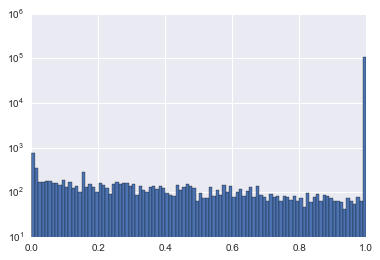

In [38]:
_ = plt.hist(bacteria_ko_enriched['bh_p'], bins=100, log=True)

In [41]:
grouped_bacteria_ko_enriched = bacteria_ko_enriched.groupby('module')
bacteria_pathway_enriched_dict = dict()
for module, group in grouped_bacteria_ko_enriched:
    kos = set(group.index[group.bh_p<.05].get_level_values('ko'))
    for pathway, pathway_kos in pathways.iteritems():
        pathway_present = set(pathway_kos)
        overlap = kos & pathway_present
        if len(overlap) != 0:
            prob = hypergeom.sf(len(overlap), len(genome_table.ids(axis='observation')), len(pathway_present), len(kos))
            bacteria_pathway_enriched_dict[(module, pathway)] = [len(pathway_present), len(overlap), prob]
        else:
            bacteria_pathway_enriched_dict[(module, pathway)] = [len(pathway_present), len(overlap), 1]
bacteria_pathway_enriched = pd.DataFrame(bacteria_pathway_enriched_dict, index=["pathway size", "overlap", "probability"]).transpose()
bacteria_pathway_enriched.columns = ["pathway size", "overlap", "probability"]
bacteria_pathway_enriched['probability_adjusted'] = p_adjust(bacteria_pathway_enriched['probability'])
bacteria_pathway_enriched['log_probability_adjusted'] = -1*np.log10(bacteria_pathway_enriched.probability_adjusted+1e-10)

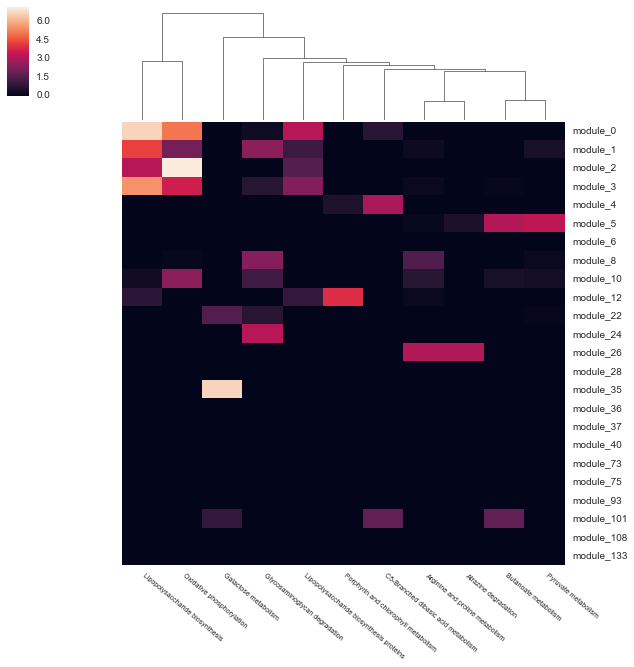

In [42]:
bacteria_enriched_sigs = bacteria_pathway_enriched.unstack()['log_probability_adjusted']
bacteria_enriched_sigs = bacteria_enriched_sigs.reindex([i for i in modules.keys() if i in bacteria_enriched_sigs.index])
cols_to_keep = [col for col in bacteria_enriched_sigs.columns if np.any(bacteria_enriched_sigs[col] > -1*np.log(.05))]
bacteria_enriched_sigs = bacteria_enriched_sigs[cols_to_keep]
g = sns.clustermap(bacteria_enriched_sigs, row_cluster=False)
_ = plt.setp(g.ax_heatmap.get_xticklabels(), rotation=365-45, ha='left', fontsize=7)
_ = plt.setp(g.ax_heatmap.get_yticklabels(), fontsize=10, rotation=0)